# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import BayesianEstimator, performance_stats, get_date_range, METRICS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_cost='transaction_cost'

# Data

In [4]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-12-31 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [5]:
df_prices = fund.df_prices
df_prices_fees = fund._get_prices_after_fee(df_prices, fee)

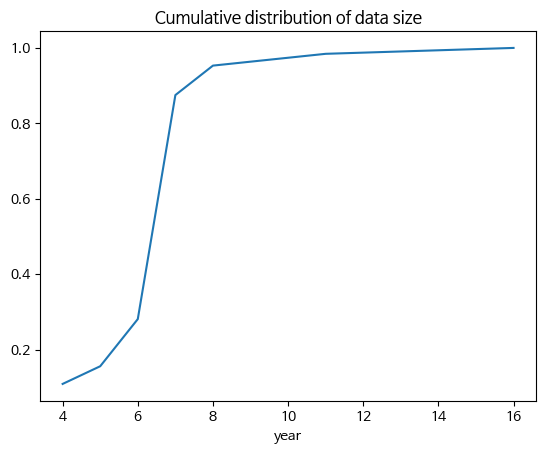

In [6]:
days_in_year = fund.days_in_year
df_year = get_date_range(df_prices).loc[:, 'n'].div(days_in_year).rename('year')
_ = df_year.groupby(df_year.round()).count().cumsum().div(df_year.count()).plot(title='Cumulative distribution of data size')

# Bayesian

*revert data to original montly for estimation*

In [7]:
days_in_year = 12
df_prc = df_prices_fees.resample('M').last()

## 1 Year Rate of Return

In [8]:
freq_year = 1
min_year = 4 # min data size

In [9]:
file_est = f'fund_f{freq_year}y_s{min_year}y_250109'
file_est

'fund_f1y_s4y_250109'

### Split

In [10]:
tickers = df_year.loc[df_year >= min_year].index.to_list()
len(tickers)

58

In [11]:
n = freq_year * days_in_year
df_p = df_prc[tickers]
df_train = df_p.iloc[:-n]
df_val = df_p.iloc[-n:]

In [12]:
len(df_p), len(df_train), len(df_val)

(194, 182, 12)

### Estimate

In [13]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [14]:
freq = freq_year * days_in_year
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, total_return]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 163 seconds.


data/fund_f1y_s4y_250109.pkl saved


*Load*

In [14]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_f1y_s4y_250109.pkl loaded


#### Visualize

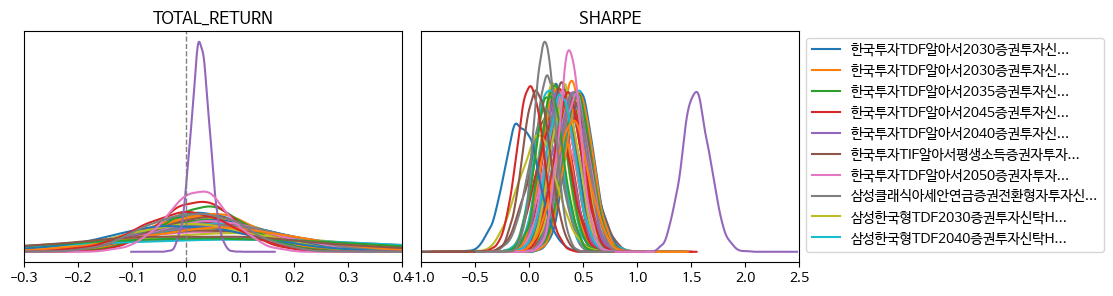

In [15]:
#xlims = None
xlims = [(-0.3, 0.4), (-1, 2.5)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

### Compare

In [16]:
#var_name = 'cagr'
var_name = 'total_return' # freq 1y
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5, df=df_s: df.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

In [17]:
#df_s.isna().any(axis=1).sum()
#df_s = df_s.dropna()

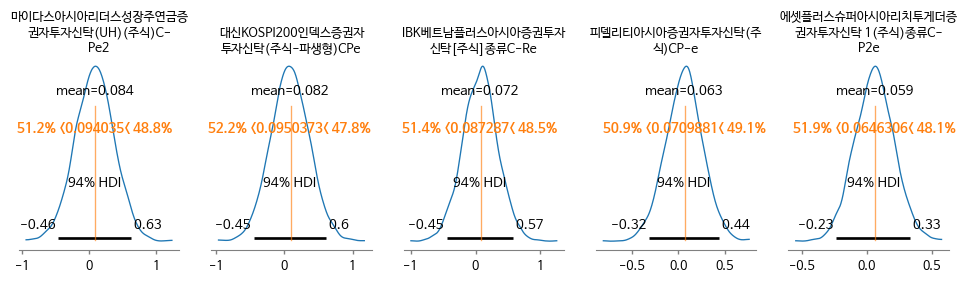

In [18]:
t0 = pick(0)
kw = dict(
    ref_val='default', 
    figsize=(12,2.5), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

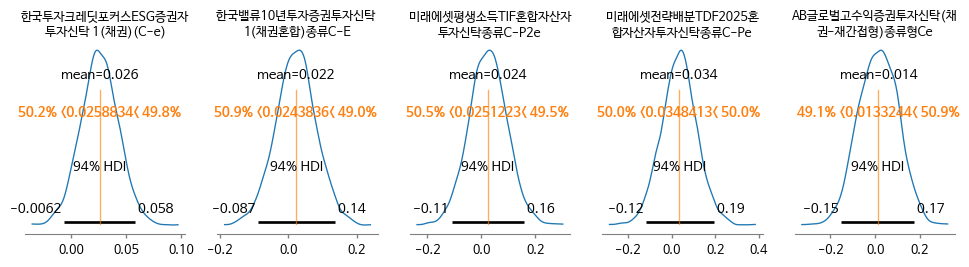

In [19]:
t1 = pick(1)
be.plot_posterior(var_name, t1, **kw)

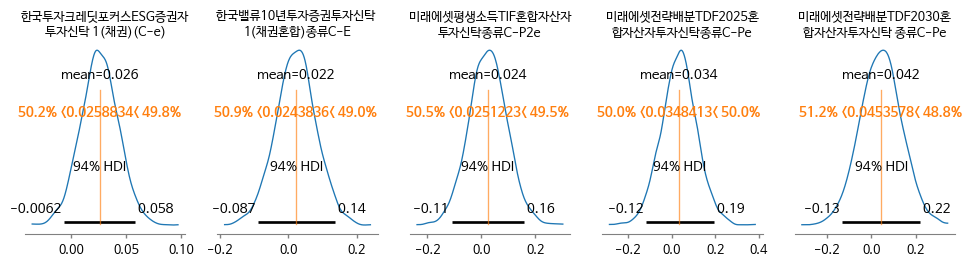

In [20]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

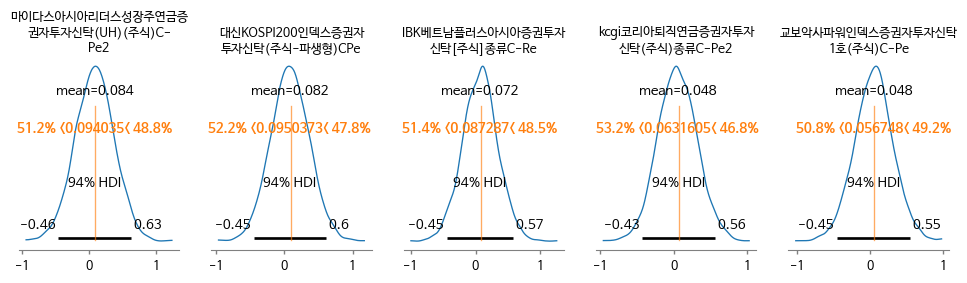

In [21]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

### Validate

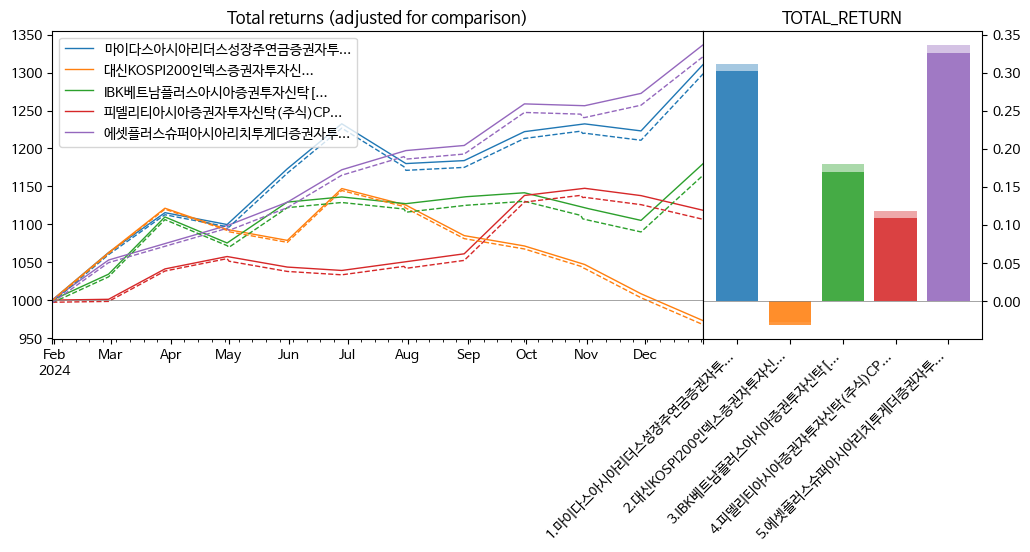

In [22]:
m = var_name
start = df_val.index.min()
fund.plot(t0, fee=fee, base=1000, metric=m, start_date=start)

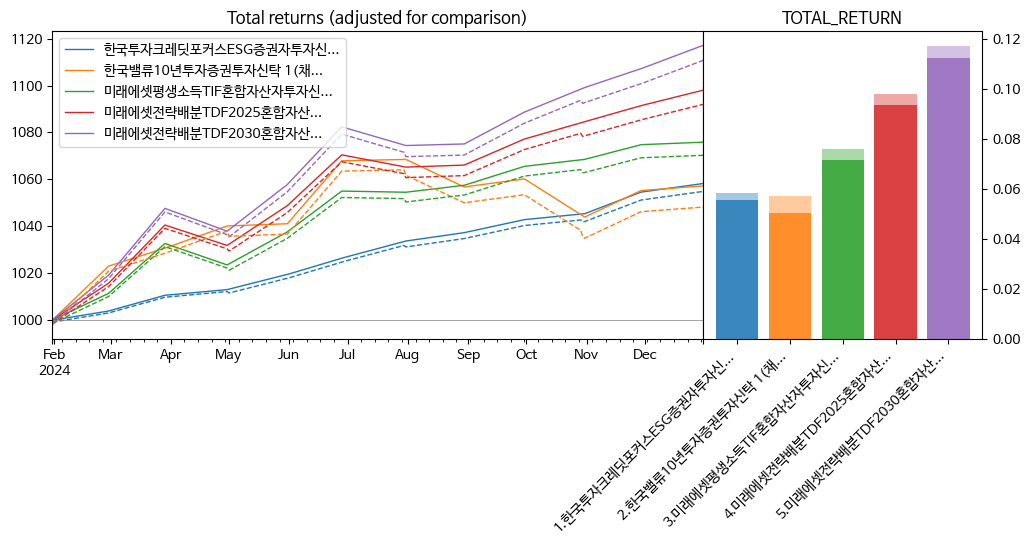

In [23]:
fund.plot(t2, fee=fee, base=1000, metric=m, start_date=start)

## 3 Year Rate of Return

In [8]:
freq_year = 3

### Min years 7

In [9]:
min_year = 7 # min data size

In [26]:
file_est = f'fund_f{freq_year}y_s{min_year}y_250109'
file_est

'fund_f3y_s7y_250109'

#### Split

In [27]:
tickers = df_year.loc[df_year >= min_year].index.to_list()
len(tickers)

39

In [28]:
n = freq_year * days_in_year
df_p = df_prc[tickers]
df_train = df_p.iloc[:-n]
df_val = df_p.iloc[-n:]

In [29]:
len(df_p), len(df_train), len(df_val)

(194, 158, 36)

#### Estimate

In [30]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [31]:
freq = freq_year * days_in_year
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, total_return]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


data/fund_f3y_s7y_250109.pkl saved


*Load*

In [31]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_f3y_s7y_250109.pkl loaded


##### Visualize

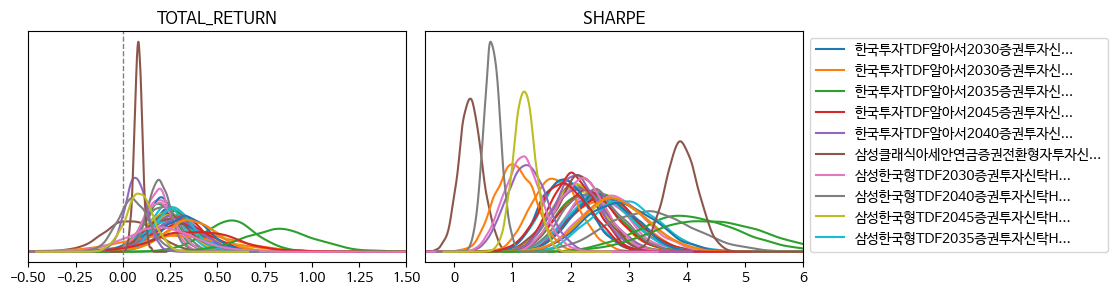

In [34]:
#xlims = None
xlims = [(-0.5, 1.5), (-0.5, 6)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

#### Compare

In [35]:
#var_name = 'cagr'
var_name = 'total_return'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5, df=df_s: df.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

In [37]:
#df_s.isna().any(axis=1).sum()
#df_s = df_s.dropna()

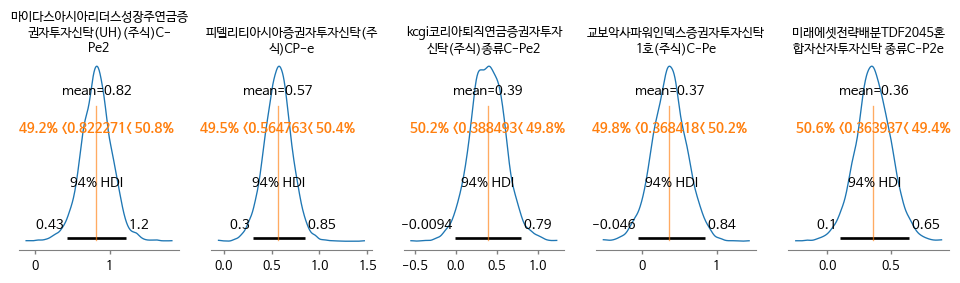

In [38]:
t0 = pick(0)
kw = dict(
    ref_val='default', 
    figsize=(12,2.5), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

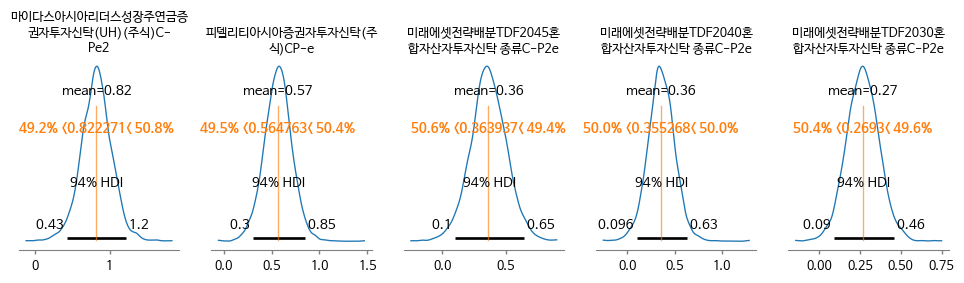

In [39]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

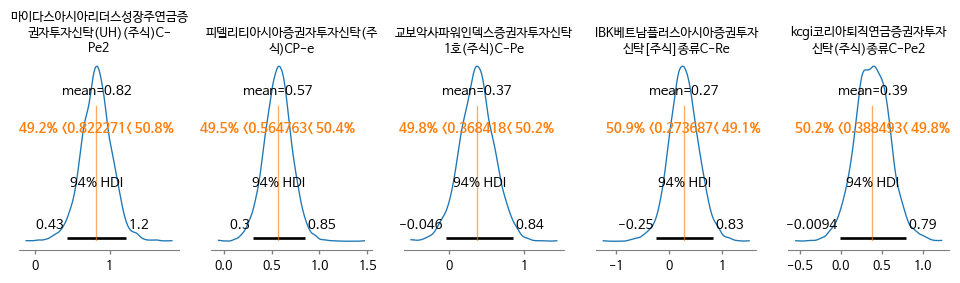

In [40]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

#### Validate

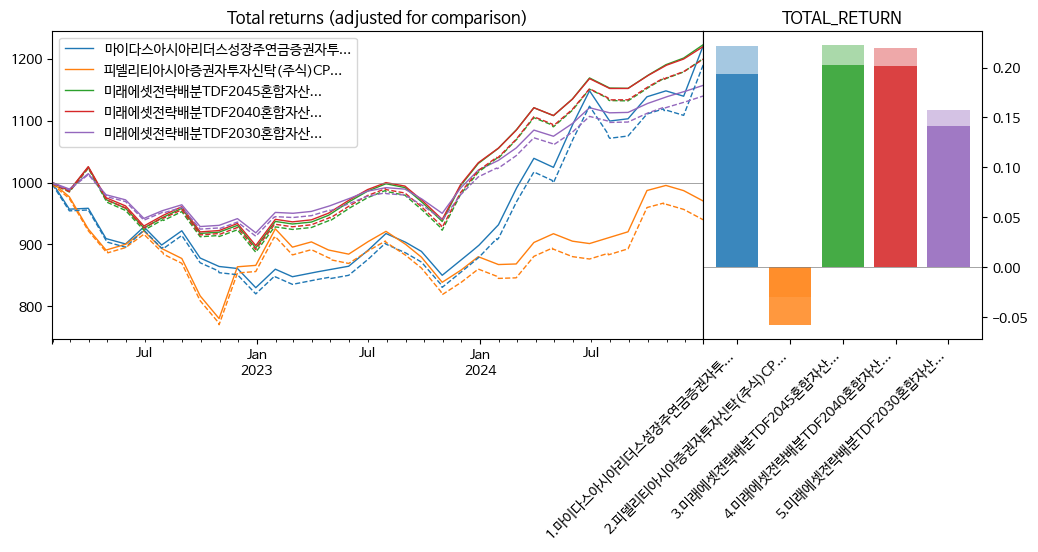

In [41]:
m = var_name
start = df_val.index.min()
fund.plot(t2, fee=fee, base=1000, metric=m, start_date=start)

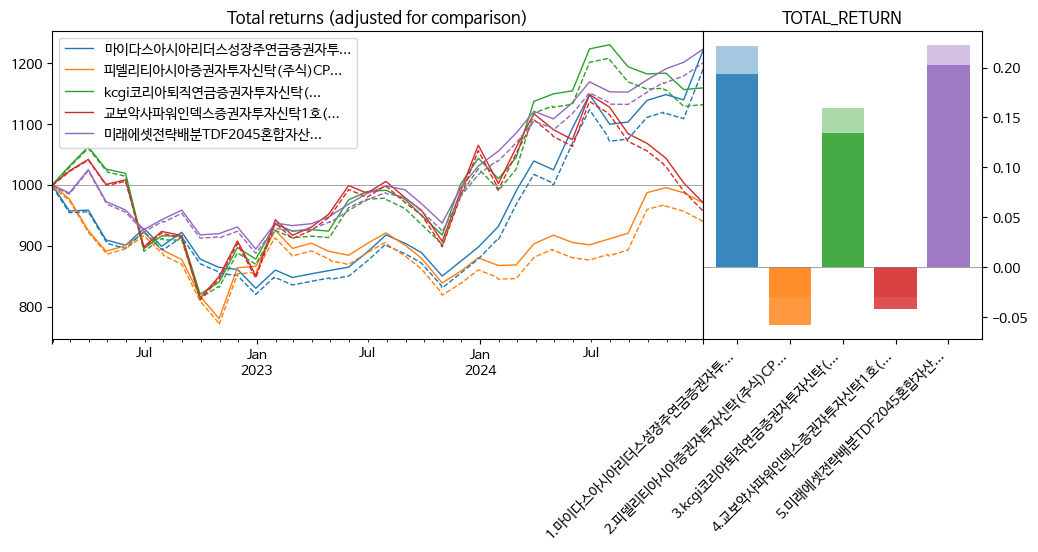

In [42]:
fund.plot(t0, fee=fee, base=1000, metric=m, start_date=start)

### Min years 3 w/o Validation

In [9]:
min_year = 3 # min data size

In [10]:
file_est = f'fund_f{freq_year}y_s{min_year}y_250109'
file_est

'fund_f3y_s3y_250109'

#### Split

In [11]:
tickers = df_year.loc[df_year >= min_year].index.to_list()
len(tickers)

64

*no validation*

In [12]:
df_p = df_prc[tickers]
df_train = df_p

In [13]:
len(df_train)

194

#### Estimate

In [14]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [15]:
freq = freq_year * days_in_year
be = BayesianEstimator(df_train, **kw)
# uncomment for new sampling 
#be.bayesian_sample(freq=freq, file=file_est, path=path_data)

*Load*

In [15]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_f3y_s3y_250109.pkl loaded


##### Visualize

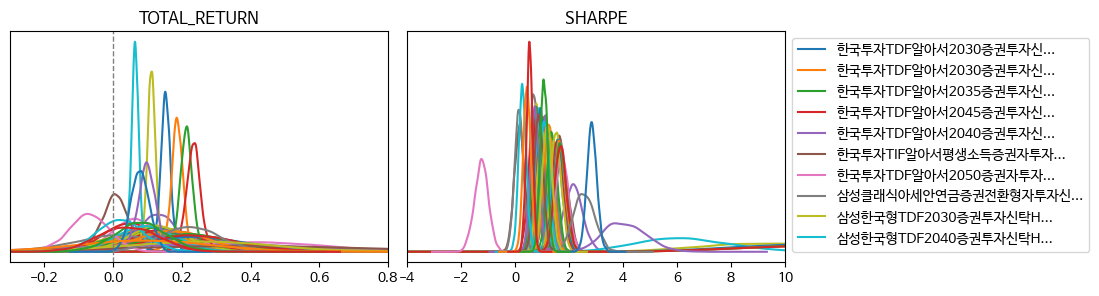

In [18]:
#xlims = None
xlims = [(-0.3, 0.8), (-4, 10)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

#### Compare

In [27]:
var_name = 'total_return'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5: df_s.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

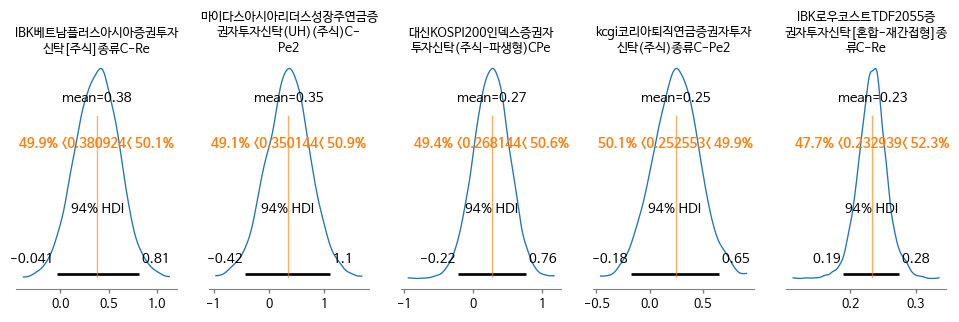

In [28]:
t0 = pick(0)
kw = dict(
    ref_val='default', 
    figsize=(12,3), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

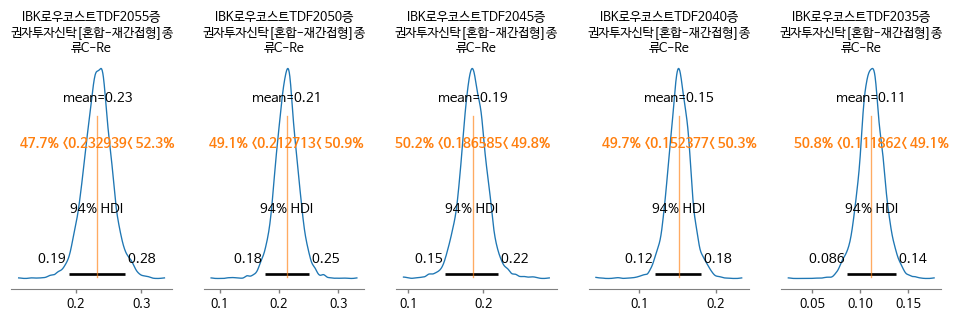

In [20]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

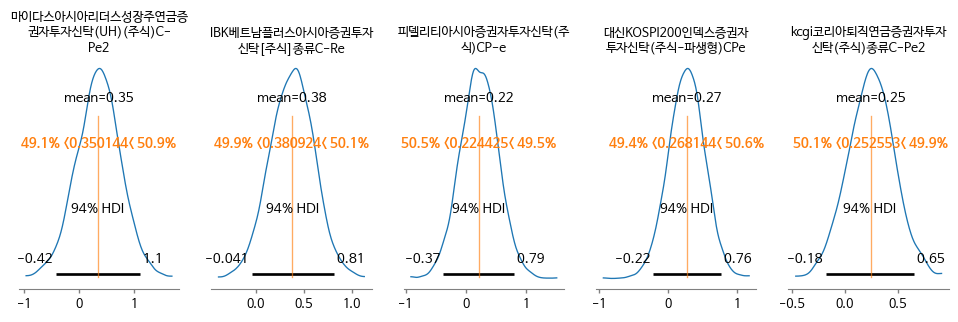

In [39]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

*choice from frequentist stats*

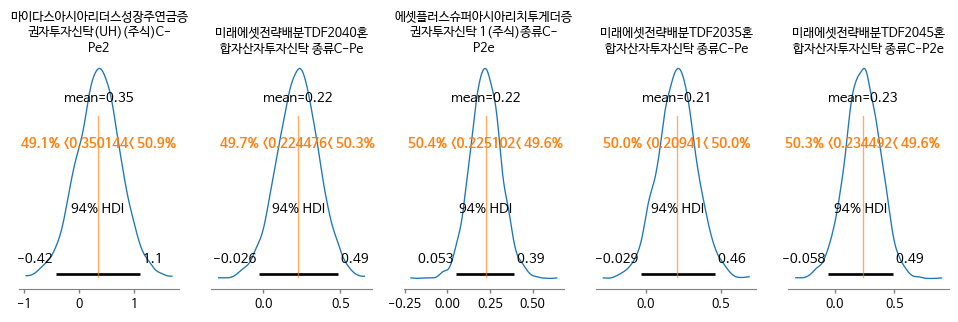

In [38]:
n = 5
t = be.get_stats(var_name).T.sort_values(var_name, ascending=False).iloc[:n].index.to_list()
be.plot_posterior(var_name, t, **kw)

#### Cases

##### TDF

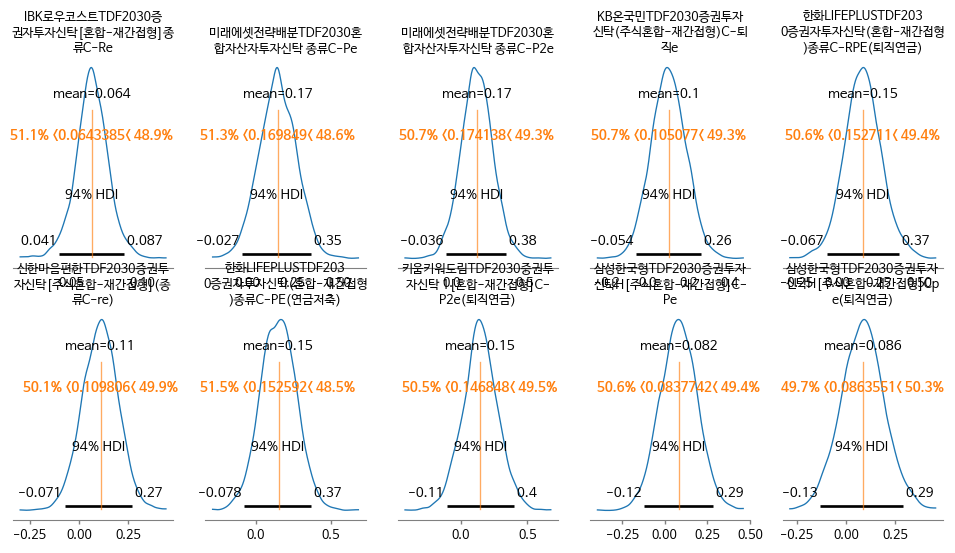

In [71]:
from math import ceil
tdf = 'tdf2030'
t9 = pick(2, 99)
t9 = [x for x in t9 if tdf in fund.security_names[x].lower()]
grid = (ceil(len(t9)/5), 5)
be.plot_posterior(var_name, t9, **{**kw, 'grid':grid, 'figsize':(12,3*grid[0])})

##### Asia

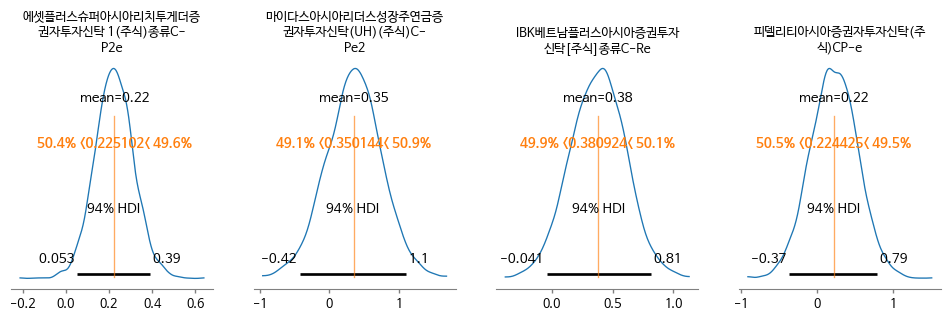

In [72]:
t9 = ['K55364CF7048','K55303BT4176','K55234BY9966','K55235BW6799']
grid = (1,4)
be.plot_posterior(var_name, t9, **{**kw, 'grid':grid, 'figsize':(12,3*grid[0])})

In [74]:
fund.get_names(t9)

0) K55364CF7048: 에셋플러스슈퍼아시아리치투게더증권자투자신탁 1(주식)종류C-P2e
1) K55303BT4176: 마이다스아시아리더스성장주연금증권자투자신탁(UH)(주식)C-Pe2
2) K55234BY9966: IBK베트남플러스아시아증권투자신탁[주식]종류C-Re
3) K55235BW6799: 피델리티아시아증권자투자신탁(주식)CP-e

# Visualize

In [77]:
from pf_dash import create_app

In [78]:
df_prc = df_prices.resample('M').last()
df_prc_f = df_prices_fees[tickers].resample('M').last()
fund_name = fund.security_names

In [79]:
#tickers = fund_name.keys()

In [19]:
#tickers = list(set(t + t0 + t2 + t3))
#tickers = t2
tickers = ['K55364CF7048','K55303BT4176','K55234BY9966','K55235BW6799'] # asia
#tickers = ['K55301BU6253', 'K55234DF2822', 'K55210BU2435', 'K55213C51890'] # tdf2040
#tickers = ['K55234DF2988','K55301BU5479', 'K55213C50702', 'K55210BU2450'] # tdf2045

In [81]:
ticker_dropdown = [{'label':v, 'value':v, 'title':fund_name[v], 'search':fund_name[v]} for v in tickers]
data_prc = {'before fees':df_prc[tickers], 'after fees':df_prc_f[tickers]}

In [82]:
create_app(data_prc, ticker_dropdown, fund_name=fund_name, legend=True)

In [47]:
fund.get_names(tickers)

0) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
1) K55210BU2450: 신한마음편한TDF2045증권투자신탁[주식혼합-재간접형](종류C-re)
2) K55213C50702: 한화LIFEPLUSTDF2045증권투자신탁(혼합-재간접형)C-RPE(퇴직연금)
3) K55234DF2988: IBK로우코스트TDF2045증권자투자신탁[혼합-재간접형]종류C-Re

## Density

In [67]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gaussian_kde


def calculate_hdi(df, interval=0.94):
    """
    Function to calculate the 94% HDI for each Ticker
    Assuming df has columns: x, density, Ticker
    """
    hdi_results = []  # To store results

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].sort_values(by='density', ascending=False)  # Sort by density
        
        # Normalize density to sum to 1 (probability distribution)
        ticker_data['cumulative_density'] = ticker_data['density'].cumsum() / ticker_data['density'].sum()
        
        # Find the values where cumulative density is within the desired interval (94% HDI)
        lower_bound = ticker_data[ticker_data['cumulative_density'] >= (1 - interval) / 2].iloc[0]['x']
        upper_bound = ticker_data[ticker_data['cumulative_density'] <= 1 - (1 - interval) / 2].iloc[-1]['x']
        
        hdi_results.append({
            'Ticker': ticker,
            'HDI_lower': lower_bound,
            'HDI_upper': upper_bound
        })
    
    return pd.DataFrame(hdi_results)


def plot_posterior(trace, tickers=None, var_name='total_return', n_points = 200, security_names=None):
    # Load posterior data
    posterior = trace.posterior
    
    # Specify variable and coordinates
    coords = {"ticker": tickers}  # Coordinates to filter
    
    # Average over the chain dimension, keep the draw dimension
    averaged_data = posterior[var_name].sel(**coords).mean(dim="chain")
    
    # Convert to a DataFrame for Plotly
    df_dst = (averaged_data.stack(sample=["draw"])  # Combine draw dimension into a single index
              .to_pandas()  # Convert to pandas DataFrame
              .T)
    
    # Example: KDE computation for the DataFrame
    kde_data = []  # To store results
    x_values = np.linspace(df_dst.min().min(), df_dst.max().max(), n_points)  # Define global x range
    
    for ticker in df_dst.columns:
        ticker_samples = df_dst[ticker].values  # Extract samples for the ticker
        
        # Compute KDE
        kde = gaussian_kde(ticker_samples)
        density = kde(x_values)  # Compute density for the range
        
        # Store results in a DataFrame
        kde_data.append(pd.DataFrame({
            "x": x_values,
            "density": density,
            "Ticker": ticker
        }))
    
    # Combine all KDE data into a single DataFrame
    df_dst = pd.concat(kde_data, ignore_index=True)

    # Plot using Plotly
    fig = px.line(
        df_dst,
        x="x",
        y="density",
        color="Ticker",
        title=f"Density of {var_name.upper()}",
        #labels={"x": "Parameter Value", "density": "Density"},
    )
    fig.for_each_trace(lambda x: x.update(name=security_names[x.name]))
    fig.update_layout(
        yaxis=dict(
            title='',             # Remove y-axis title (label)
            showticklabels=False  # Hide y-tick labels
        )
    )
    fig.show()
    #return df_dst

In [54]:
file = 'fund_f3y_s3y_250109'
fund = PM.create_universe('UV_FUND')
security_names = fund.security_names

kw = dict(
    days_in_year = days_in_year,
    security_names = security_names
)
be = BayesianEstimator.create(file, path_data, **kw)

64 securities from 2008-11-28 to 2024-12-31 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
data/fund_f3y_s3y_250109.pkl loaded


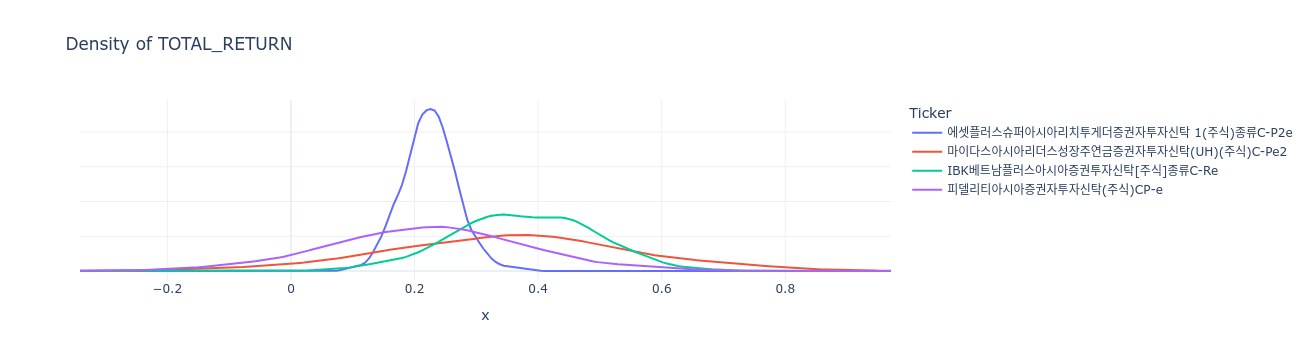

In [68]:
df_dst = plot_posterior(be.bayesian_data['trace'], tickers, security_names=security_names)

In [69]:
calculate_hdi(df_dst)

,Ticker,HDI_lower,HDI_upper
0,K55364CF7048,0.225803,0.126874
1,K55303BT4176,0.364304,-0.090769
2,K55234BY9966,0.337923,0.614924
3,K55235BW6799,0.232399,-0.136936


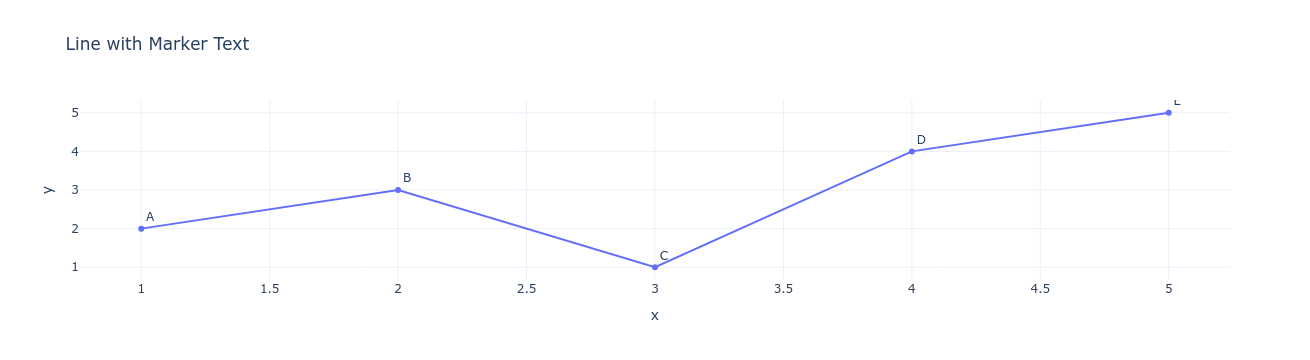

In [66]:
import plotly.express as px
import pandas as pd

# Example DataFrame with a simple line plot
df = pd.DataFrame({
    'x': [1, 2, 3, 4, 5],
    'y': [2, 3, 1, 4, 5],
    'text': ['A', 'B', 'C', 'D', 'E']  # Text labels to display at each point
})

# Create the line plot with marker text
fig = px.line(df, x='x', y='y', text='text', title='Line with Marker Text')

# Update layout to adjust text position if needed
fig.update_traces(textposition='top right')  # Adjust position of text

# Show the plot
fig.show()

In [70]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gaussian_kde

def calculate_hdi(df, interval=0.94):
    """Function to calculate the 94% HDI for each Ticker"""
    hdi_results = []  # To store results

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].sort_values(by='density', ascending=False)  # Sort by density
        
        # Normalize density to sum to 1 (probability distribution)
        ticker_data['cumulative_density'] = ticker_data['density'].cumsum() / ticker_data['density'].sum()
        
        # Find the values where cumulative density is within the desired interval (94% HDI)
        lower_bound = ticker_data[ticker_data['cumulative_density'] >= (1 - interval) / 2].iloc[0]['x']
        upper_bound = ticker_data[ticker_data['cumulative_density'] <= 1 - (1 - interval) / 2].iloc[-1]['x']
        
        hdi_results.append({
            'Ticker': ticker,
            'HDI_lower': lower_bound,
            'HDI_upper': upper_bound
        })
    
    return pd.DataFrame(hdi_results)

def plot_posterior(trace, tickers=None, var_name='total_return', n_points=200, security_names=None):
    # Load posterior data
    posterior = trace.posterior
    
    # Specify variable and coordinates
    coords = {"ticker": tickers}  # Coordinates to filter
    
    # Average over the chain dimension, keep the draw dimension
    averaged_data = posterior[var_name].sel(**coords).mean(dim="chain")
    
    # Convert to a DataFrame for Plotly
    df_dst = (averaged_data.stack(sample=["draw"])  # Combine draw dimension into a single index
              .to_pandas()  # Convert to pandas DataFrame
              .T)
    
    # Example: KDE computation for the DataFrame
    kde_data = []  # To store results
    x_values = np.linspace(df_dst.min().min(), df_dst.max().max(), n_points)  # Define global x range
    
    for ticker in df_dst.columns:
        ticker_samples = df_dst[ticker].values  # Extract samples for the ticker
        
        # Compute KDE
        kde = gaussian_kde(ticker_samples)
        density = kde(x_values)  # Compute density for the range
        
        # Store results in a DataFrame
        kde_data.append(pd.DataFrame({
            "x": x_values,
            "density": density,
            "Ticker": ticker
        }))
    
    # Combine all KDE data into a single DataFrame
    df_dst = pd.concat(kde_data, ignore_index=True)
    
    # Calculate the HDI for each ticker
    hdi_df = calculate_hdi(df_dst)
    
    # Plot using Plotly
    fig = px.line(
        df_dst,
        x="x",
        y="density",
        color="Ticker",
        title=f"Density of {var_name.upper()}",
    )
    
    # Add horizontal lines for HDI (94% interval)
    for _, row in hdi_df.iterrows():
        ticker = row['Ticker']
        hdi_lower = row['HDI_lower']
        hdi_upper = row['HDI_upper']
        
        # Add horizontal lines at the HDI bounds
        fig.add_hline(
            y=df_dst[df_dst['Ticker'] == ticker].density.max(),  # Use the max density to position the line
            line=dict(color='red', dash='dash'),
            annotation_text=f'{ticker} HDI: {hdi_lower:.2f} - {hdi_upper:.2f}',
            annotation_position='top left'
        )
    
    # Customize layout and hide y-axis labels
    fig.for_each_trace(lambda x: x.update(name=security_names[x.name] if security_names else x.name))
    fig.update_layout(
        yaxis=dict(
            title='',             # Remove y-axis title (label)
            showticklabels=False  # Hide y-tick labels
        )
    )
    
    # Show plot
    fig.show()


In [72]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gaussian_kde

def calculate_hdi(df, interval=0.94):
    """Function to calculate the 94% HDI for each Ticker"""
    hdi_results = []  # To store results

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].sort_values(by='density', ascending=False)  # Sort by density
        
        # Normalize density to sum to 1 (probability distribution)
        ticker_data['cumulative_density'] = ticker_data['density'].cumsum() / ticker_data['density'].sum()
        
        # Find the values where cumulative density is within the desired interval (94% HDI)
        lower_bound = ticker_data[ticker_data['cumulative_density'] >= (1 - interval) / 2].iloc[0]['x']
        upper_bound = ticker_data[ticker_data['cumulative_density'] <= 1 - (1 - interval) / 2].iloc[-1]['x']
        
        hdi_results.append({
            'Ticker': ticker,
            'HDI_lower': lower_bound,
            'HDI_upper': upper_bound
        })
    
    return pd.DataFrame(hdi_results)

def plot_posterior(trace, tickers=None, var_name='total_return', n_points=200, security_names=None):
    # Load posterior data
    posterior = trace.posterior
    
    # Specify variable and coordinates
    coords = {"ticker": tickers}  # Coordinates to filter
    
    # Average over the chain dimension, keep the draw dimension
    averaged_data = posterior[var_name].sel(**coords).mean(dim="chain")
    
    # Convert to a DataFrame for Plotly
    df_dst = (averaged_data.stack(sample=["draw"])  # Combine draw dimension into a single index
              .to_pandas()  # Convert to pandas DataFrame
              .T)
    
    # Example: KDE computation for the DataFrame
    kde_data = []  # To store results
    x_values = np.linspace(df_dst.min().min(), df_dst.max().max(), n_points)  # Define global x range
    
    for ticker in df_dst.columns:
        ticker_samples = df_dst[ticker].values  # Extract samples for the ticker
        
        # Compute KDE
        kde = gaussian_kde(ticker_samples)
        density = kde(x_values)  # Compute density for the range
        
        # Store results in a DataFrame
        kde_data.append(pd.DataFrame({
            "x": x_values,
            "density": density,
            "Ticker": ticker
        }))
    
    # Combine all KDE data into a single DataFrame
    df_dst = pd.concat(kde_data, ignore_index=True)
    
    # Calculate the HDI for each ticker
    hdi_df = calculate_hdi(df_dst)
    
    # Plot using Plotly
    fig = px.line(
        df_dst,
        x="x",
        y="density",
        color="Ticker",
        title=f"Density of {var_name.upper()}",
    )
    
    # Add vertical lines for HDI (94% interval) and add them to the legend
    for _, row in hdi_df.iterrows():
        ticker = row['Ticker']
        hdi_lower = row['HDI_lower']
        hdi_upper = row['HDI_upper']
        
        # Add vertical dashed lines for HDI bounds (lower and upper)
        fig.add_vline(
            x=hdi_lower,
            line=dict(color='red', dash='dash'),
            annotation_text=f'{ticker} HDI Lower: {hdi_lower:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI Lower'  # Include in legend
        )
        
        fig.add_vline(
            x=hdi_upper,
            line=dict(color='blue', dash='dash'),
            annotation_text=f'{ticker} HDI Upper: {hdi_upper:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI Upper'  # Include in legend
        )
    
    # Customize layout and hide y-axis labels
    fig.for_each_trace(lambda x: x.update(name=security_names[x.name] if security_names else x.name))
    fig.update_layout(
        yaxis=dict(
            title='',             # Remove y-axis title (label)
            showticklabels=False  # Hide y-tick labels
        )
    )
    
    # Show plot
    fig.show()


In [76]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gaussian_kde

def calculate_hdi(df, interval=0.94):
    """Function to calculate the 94% HDI for each Ticker"""
    hdi_results = []  # To store results

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].sort_values(by='density', ascending=False)  # Sort by density
        
        # Normalize density to sum to 1 (probability distribution)
        ticker_data['cumulative_density'] = ticker_data['density'].cumsum() / ticker_data['density'].sum()
        
        # Find the values where cumulative density is within the desired interval (94% HDI)
        lower_bound = ticker_data[ticker_data['cumulative_density'] >= (1 - interval) / 2].iloc[0]['x']
        upper_bound = ticker_data[ticker_data['cumulative_density'] <= 1 - (1 - interval) / 2].iloc[-1]['x']
        
        hdi_results.append({
            'Ticker': ticker,
            'HDI_lower': lower_bound,
            'HDI_upper': upper_bound
        })
    
    return pd.DataFrame(hdi_results)

def plot_posterior(trace, tickers=None, var_name='total_return', n_points=200, security_names=None):
    # Load posterior data
    posterior = trace.posterior
    
    # Specify variable and coordinates
    coords = {"ticker": tickers}  # Coordinates to filter
    
    # Average over the chain dimension, keep the draw dimension
    averaged_data = posterior[var_name].sel(**coords).mean(dim="chain")
    
    # Convert to a DataFrame for Plotly
    df_dst = (averaged_data.stack(sample=["draw"])  # Combine draw dimension into a single index
              .to_pandas()  # Convert to pandas DataFrame
              .T)
    
    # Example: KDE computation for the DataFrame
    kde_data = []  # To store results
    x_values = np.linspace(df_dst.min().min(), df_dst.max().max(), n_points)  # Define global x range
    
    for ticker in df_dst.columns:
        ticker_samples = df_dst[ticker].values  # Extract samples for the ticker
        
        # Compute KDE
        kde = gaussian_kde(ticker_samples)
        density = kde(x_values)  # Compute density for the range
        
        # Store results in a DataFrame
        kde_data.append(pd.DataFrame({
            "x": x_values,
            "density": density,
            "Ticker": ticker
        }))
    
    # Combine all KDE data into a single DataFrame
    df_dst = pd.concat(kde_data, ignore_index=True)
    
    # Calculate the HDI for each ticker
    hdi_df = calculate_hdi(df_dst)
    
    # Plot using Plotly
    fig = px.line(
        df_dst,
        x="x",
        y="density",
        color="Ticker",
        title=f"Density of {var_name.upper()}",
    )
    
    # Add vertical lines for HDI (94% interval) and add them to the legend
    for _, row in hdi_df.iterrows():
        ticker = row['Ticker']
        hdi_lower = row['HDI_lower']
        hdi_upper = row['HDI_upper']
        
        # Add vertical dashed lines for HDI bounds (lower and upper)
        # Use y=0 for baseline position (under the density line)
        fig.add_vline(
            x=hdi_lower,
            line=dict(color='red', dash='dash'),
            annotation_text=f'{ticker} HDI Lower: {hdi_lower:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI'  # Include in legend under the same group
        )
        
        fig.add_vline(
            x=hdi_upper,
            line=dict(color='blue', dash='dash'),
            annotation_text=f'{ticker} HDI Upper: {hdi_upper:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI'  # Include in legend under the same group
        )
    
    # Customize layout and hide y-axis labels
    fig.for_each_trace(lambda x: x.update(name=security_names[x.name] if security_names else x.name))
    fig.update_layout(
        yaxis=dict(
            title='',             # Remove y-axis title (label)
            showticklabels=False  # Hide y-tick labels
        )
    )
    
    # Show plot
    fig.show()


In [79]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gaussian_kde

def calculate_hdi(df, interval=0.94):
    """Function to calculate the 94% HDI for each Ticker"""
    hdi_results = []  # To store results

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].sort_values(by='density', ascending=False)  # Sort by density
        
        # Normalize density to sum to 1 (probability distribution)
        ticker_data['cumulative_density'] = ticker_data['density'].cumsum() / ticker_data['density'].sum()
        
        # Find the values where cumulative density is within the desired interval (94% HDI)
        lower_bound = ticker_data[ticker_data['cumulative_density'] >= (1 - interval) / 2].iloc[0]['x']
        upper_bound = ticker_data[ticker_data['cumulative_density'] <= 1 - (1 - interval) / 2].iloc[-1]['x']
        
        hdi_results.append({
            'Ticker': ticker,
            'HDI_lower': lower_bound,
            'HDI_upper': upper_bound
        })
    
    return pd.DataFrame(hdi_results)

def plot_posterior(trace, tickers=None, var_name='total_return', n_points=200, security_names=None):
    # Load posterior data
    posterior = trace.posterior
    
    # Specify variable and coordinates
    coords = {"ticker": tickers}  # Coordinates to filter
    
    # Average over the chain dimension, keep the draw dimension
    averaged_data = posterior[var_name].sel(**coords).mean(dim="chain")
    
    # Convert to a DataFrame for Plotly
    df_dst = (averaged_data.stack(sample=["draw"])  # Combine draw dimension into a single index
              .to_pandas()  # Convert to pandas DataFrame
              .T)
    
    # Example: KDE computation for the DataFrame
    kde_data = []  # To store results
    x_values = np.linspace(df_dst.min().min(), df_dst.max().max(), n_points)  # Define global x range
    
    for ticker in df_dst.columns:
        ticker_samples = df_dst[ticker].values  # Extract samples for the ticker
        
        # Compute KDE
        kde = gaussian_kde(ticker_samples)
        density = kde(x_values)  # Compute density for the range
        
        # Store results in a DataFrame
        kde_data.append(pd.DataFrame({
            "x": x_values,
            "density": density,
            "Ticker": ticker
        }))
    
    # Combine all KDE data into a single DataFrame
    df_dst = pd.concat(kde_data, ignore_index=True)
    
    # Calculate the HDI for each ticker
    hdi_df = calculate_hdi(df_dst)
    
    # Plot using Plotly
    fig = px.line(
        df_dst,
        x="x",
        y="density",
        color="Ticker",
        title=f"Density of {var_name.upper()}",
    )
    
    # Get the color mapping of each ticker from the plot
    colors = {trace.name: trace.line.color for trace in fig.data}

    # Add vertical lines for HDI (94% interval) and add them to the legend
    for _, row in hdi_df.iterrows():
        ticker = row['Ticker']
        hdi_lower = row['HDI_lower']
        hdi_upper = row['HDI_upper']
        
        # Use the color of the corresponding ticker from the plot
        color = colors.get(ticker, 'black')  # Default to black if color is not found
        
        # Add vertical dashed lines for HDI bounds (lower and upper) using the same color
        fig.add_vline(
            x=hdi_lower,
            line=dict(color=color, dash='dash'),
            annotation_text=f'{ticker} HDI Lower: {hdi_lower:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI'  # Include in legend under the same group
        )
        
        fig.add_vline(
            x=hdi_upper,
            line=dict(color=color, dash='dash'),
            annotation_text=f'{ticker} HDI Upper: {hdi_upper:.2f}',
            annotation_position='top left',
            name=f'{ticker} HDI'  # Include in legend under the same group
        )
    
    # Customize layout and hide y-axis labels
    fig.for_each_trace(lambda x: x.update(name=security_names[x.name] if security_names else x.name))
    fig.update_layout(
        yaxis=dict(
            title='',             # Remove y-axis title (label)
            showticklabels=False  # Hide y-tick labels
        )
    )
    
    # Show plot
    fig.show()


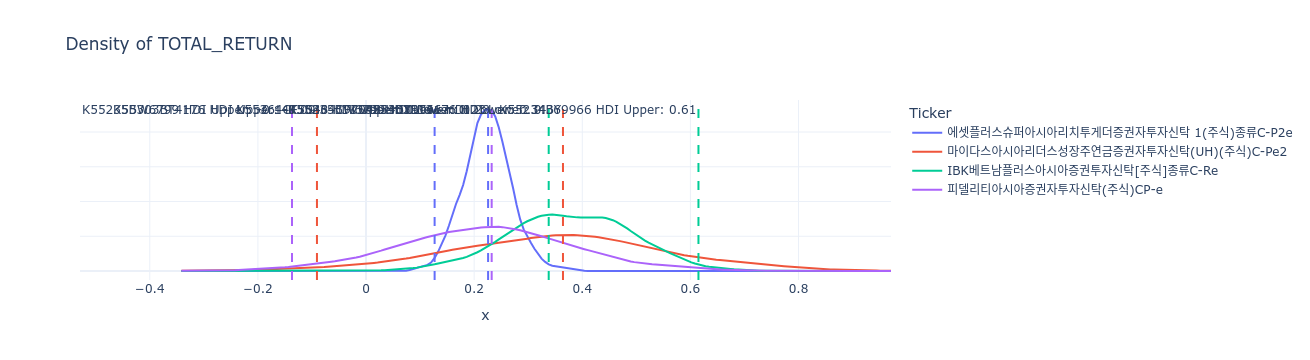

In [80]:
plot_posterior(be.bayesian_data['trace'], tickers, security_names=security_names)